In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '5'

/home/lab/plongour/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
SENSOR_SIZE = (128, 128, 2)
batch_size = 64

Dataset_path = '../data'
Workers = 8
Targetnum = 11

Test_every_iteration = None
Name_suffix = '_step2_nbEvents'
Savemodel_path = './savemodels_DVS/'
Record_path = './recorddata_DVS/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)

_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
def convert_to_event_representation(frame_sequence):
    time_steps, channels, height, width = frame_sequence.shape  # (T, 2, H, W)
    
    middle_idx = time_steps // 2  # Index de la frame du milieu
    middle_frame = frame_sequence[middle_idx]  # (2, H, W)
    
    # Somme des canaux positifs et négatifs
    event_sum = (middle_frame[0] + middle_frame[1]).astype(np.float32)  # (H, W)
    event_sum /= np.max(event_sum) if np.max(event_sum) > 0 else event_sum  # Normalisation
    
    return event_sum  # (H, W)



# Set paths
output_dir = "./processed_dvsgesture"
train_data_path = os.path.join(output_dir, "train_data"+Name_suffix+".pkl")
test_data_path = os.path.join(output_dir, "test_data"+Name_suffix+".pkl")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if processed data already exists
if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    # Load processed data
    with open(train_data_path, "rb") as f:
        train_images, train_labels = pickle.load(f)
    with open(test_data_path, "rb") as f:
        test_images, test_labels = pickle.load(f)
    print("Loaded preprocessed data from files")
else:
    # Load dataset
    transform = transforms.Compose([
        transforms.Denoise(filter_time=10000),
        transforms.ToFrame(sensor_size=SENSOR_SIZE, time_window=25000)
    ])

    dataset_train = tonic.datasets.DVSGesture(save_to=Dataset_path, train=True, transform=transform)
    dataset_test = tonic.datasets.DVSGesture(save_to=Dataset_path, train=False, transform=transform)

    # Process training data
    train_images = []
    train_labels = []
    for i, (frames, label) in enumerate(dataset_train):
        if i % 100 == 0:
            print(f"Processing training sample {i}/{len(dataset_train)}")
        img = convert_to_event_representation(frames)
        train_images.append(torch.FloatTensor(img))
        train_labels.append(label)
        
    # Process test data
    test_images = []
    test_labels = []
    for i, (frames, label) in enumerate(dataset_test):
        if i % 100 == 0:
            print(f"Processing test sample {i}/{len(dataset_test)}")
        img = convert_to_event_representation(frames)
        test_images.append(torch.FloatTensor(img))
        test_labels.append(label)

    
    # Save processed data
    with open(train_data_path, "wb") as f:
        pickle.dump((train_images, train_labels), f)
    with open(test_data_path, "wb") as f:
        pickle.dump((test_images, test_labels), f)
    print("Saved preprocessed data to files")


# Create dataloaders
train_data_loader = torch.utils.data.DataLoader(
    list(zip(train_images, train_labels)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=Workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    list(zip(test_images, test_labels)),
    batch_size=batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True
)

Processing training sample 0/1077
Processing training sample 100/1077
Processing training sample 200/1077
Processing training sample 300/1077
Processing training sample 400/1077
Processing training sample 500/1077
Processing training sample 600/1077
Processing training sample 700/1077
Processing training sample 800/1077
Processing training sample 900/1077
Processing training sample 1000/1077
Processing test sample 0/264
Processing test sample 100/264
Processing test sample 200/264
Saved preprocessed data to files



Statistiques du canal:

Événements:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0046
  Std: 0.0378


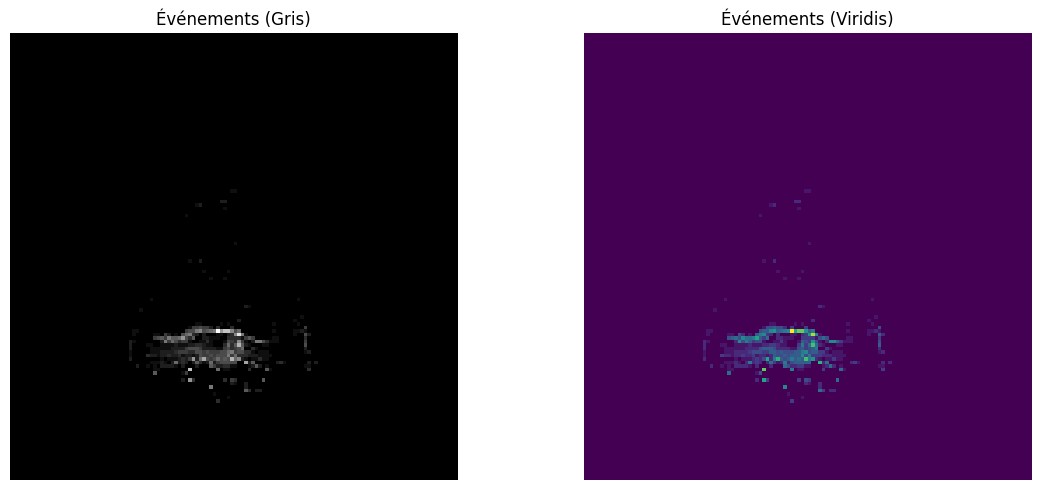

In [5]:
def visualize_event_representation(data_loader, sample_index=0):
    """
    Visualise un seul canal d'événements pour un échantillon du DataLoader,
    avec statistiques.
    
    Args:
        data_loader: PyTorch DataLoader contenant des pairs (images, labels).
        sample_index: Index de l'échantillon à visualiser (défaut: 0).
    """
    # Obtenir un batch du DataLoader
    for batch in data_loader:
        images, labels = batch
        break  # Prendre uniquement le premier batch
    
    # Sélectionner l'échantillon à l'index spécifié
    if sample_index >= images.shape[0]:
        raise ValueError(f"sample_index {sample_index} est hors limites pour un batch de taille {images.shape[0]}")
    
    # Extraire l'image (forme: (1, height, width))
    img = images[sample_index].numpy()  # Convertir le tenseur PyTorch en tableau NumPy
    
    # S'assurer que nous avons un tableau 2D même si la dimension du canal est 1
    if len(img.shape) == 3:
        event_data = img[0]  # Premier (et seul) canal
    else:
        event_data = img  # Déjà en 2D
    
    # Calculer les statistiques
    stats = {
        "Événements": {
            "min": np.min(event_data),
            "max": np.max(event_data),
            "mean": np.mean(event_data),
            "std": np.std(event_data)
        }
    }
    
    # Afficher les statistiques
    print("\nStatistiques du canal:")
    for channel, values in stats.items():
        print(f"\n{channel}:")
        print(f"  Min: {values['min']:.4f}")
        print(f"  Max: {values['max']:.4f}")
        print(f"  Mean: {values['mean']:.4f}")
        print(f"  Std: {values['std']:.4f}")
    
    # Créer une figure pour la visualisation
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot en niveaux de gris
    axes[0].imshow(event_data, cmap='gray')
    axes[0].set_title("Événements (Gris)")
    axes[0].axis('off')
    
    # Plot avec une colormap différente pour plus de contraste
    axes[1].imshow(event_data, cmap='viridis')
    axes[1].set_title("Événements (Viridis)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_event_representation(train_data_loader, sample_index=0)

In [6]:
net = Reactnet(num_classes=Targetnum, imagenet=False)

# Modifier la première couche pour accepter 1 canal au lieu de 3
net.feature[0] = firstconv3x3(1, stage_out_channel[0], 1)

In [7]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.

Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [8]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [9]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.unsqueeze(1) 
            img = img.cuda()
            label = label.cuda()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [10]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.unsqueeze(1) 
        img = img.cuda()
        label = label.cuda()
        
        out_fr = net(img)
        loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        loss.backward()

        parameters_list = []
        for name, p in net.named_parameters():
            if not 'fc' in name:
                parameters_list.append(p)
        adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
        optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [11]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=0, train_acc_top1=0.0799, train_acc_top5=0.4550, train_loss=11.1168, test_top1=0.0909, test_top5=0.4545, test_loss=9.4229, max_test_acc=0.0909, total_time=6.8180, LR=0.00100000


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=1, train_acc_top1=0.0780, train_acc_top5=0.4494, train_loss=8.6692, test_top1=0.0909, test_top5=0.4508, test_loss=8.2284, max_test_acc=0.0909, total_time=6.0993, LR=0.00099609


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=2, train_acc_top1=0.0956, train_acc_top5=0.4754, train_loss=7.3380, test_top1=0.0909, test_top5=0.4583, test_loss=4.1766, max_test_acc=0.0909, total_time=6.0890, LR=0.00099219


100%|██████████| 5/5 [00:00<00:00,  8.19it/s]


epoch=3, train_acc_top1=0.1003, train_acc_top5=0.4466, train_loss=5.1811, test_top1=0.0909, test_top5=0.4545, test_loss=3.7577, max_test_acc=0.0909, total_time=8.0251, LR=0.00098828


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=4, train_acc_top1=0.1049, train_acc_top5=0.4893, train_loss=3.7789, test_top1=0.0909, test_top5=0.4545, test_loss=3.8604, max_test_acc=0.0909, total_time=6.1178, LR=0.00098438


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=5, train_acc_top1=0.0799, train_acc_top5=0.4364, train_loss=3.6713, test_top1=0.0909, test_top5=0.3977, test_loss=3.1093, max_test_acc=0.0909, total_time=6.1174, LR=0.00098047


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


epoch=6, train_acc_top1=0.1077, train_acc_top5=0.4522, train_loss=2.8894, test_top1=0.0909, test_top5=0.4583, test_loss=2.8269, max_test_acc=0.0909, total_time=6.1146, LR=0.00097656


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=7, train_acc_top1=0.0891, train_acc_top5=0.4587, train_loss=2.8065, test_top1=0.0909, test_top5=0.4545, test_loss=3.2148, max_test_acc=0.0909, total_time=6.1071, LR=0.00097266


100%|██████████| 5/5 [00:00<00:00,  7.60it/s]


epoch=8, train_acc_top1=0.0826, train_acc_top5=0.4438, train_loss=3.1379, test_top1=0.0909, test_top5=0.4545, test_loss=3.0651, max_test_acc=0.0909, total_time=7.2618, LR=0.00096875


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


epoch=9, train_acc_top1=0.0910, train_acc_top5=0.4355, train_loss=2.9426, test_top1=0.0947, test_top5=0.4583, test_loss=2.6850, max_test_acc=0.0947, total_time=6.2471, LR=0.00096484


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


epoch=10, train_acc_top1=0.0854, train_acc_top5=0.4308, train_loss=2.8813, test_top1=0.0909, test_top5=0.4545, test_loss=2.6982, max_test_acc=0.0947, total_time=5.9217, LR=0.00096094


100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


epoch=11, train_acc_top1=0.0956, train_acc_top5=0.4717, train_loss=2.7180, test_top1=0.1061, test_top5=0.4508, test_loss=2.7430, max_test_acc=0.1061, total_time=6.0715, LR=0.00095703


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=12, train_acc_top1=0.1040, train_acc_top5=0.4596, train_loss=2.6925, test_top1=0.0909, test_top5=0.4545, test_loss=2.9500, max_test_acc=0.1061, total_time=5.9244, LR=0.00095312


100%|██████████| 5/5 [00:00<00:00,  7.63it/s]


epoch=13, train_acc_top1=0.1003, train_acc_top5=0.4550, train_loss=2.8696, test_top1=0.0909, test_top5=0.4545, test_loss=2.7759, max_test_acc=0.1061, total_time=5.9384, LR=0.00094922


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=14, train_acc_top1=0.0938, train_acc_top5=0.4578, train_loss=2.6576, test_top1=0.0909, test_top5=0.4545, test_loss=2.7840, max_test_acc=0.1061, total_time=5.8114, LR=0.00094531


100%|██████████| 5/5 [00:00<00:00,  7.77it/s]


epoch=15, train_acc_top1=0.0891, train_acc_top5=0.4457, train_loss=2.6224, test_top1=0.0909, test_top5=0.4545, test_loss=2.4746, max_test_acc=0.1061, total_time=6.4037, LR=0.00094141


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=16, train_acc_top1=0.0854, train_acc_top5=0.4475, train_loss=2.5606, test_top1=0.0909, test_top5=0.4583, test_loss=2.5234, max_test_acc=0.1061, total_time=5.7828, LR=0.00093750


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=17, train_acc_top1=0.0771, train_acc_top5=0.4680, train_loss=2.5280, test_top1=0.0909, test_top5=0.4545, test_loss=2.5804, max_test_acc=0.1061, total_time=5.7925, LR=0.00093359


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


epoch=18, train_acc_top1=0.0966, train_acc_top5=0.4513, train_loss=2.5653, test_top1=0.0947, test_top5=0.4545, test_loss=2.4896, max_test_acc=0.1061, total_time=5.7898, LR=0.00092969


100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


epoch=19, train_acc_top1=0.0938, train_acc_top5=0.4466, train_loss=2.4936, test_top1=0.0909, test_top5=0.4545, test_loss=2.5854, max_test_acc=0.1061, total_time=5.8031, LR=0.00092578


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=20, train_acc_top1=0.0836, train_acc_top5=0.4513, train_loss=2.5530, test_top1=0.0909, test_top5=0.4545, test_loss=2.5755, max_test_acc=0.1061, total_time=5.9044, LR=0.00092188


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


epoch=21, train_acc_top1=0.0975, train_acc_top5=0.4652, train_loss=2.4744, test_top1=0.0909, test_top5=0.4545, test_loss=2.5302, max_test_acc=0.1061, total_time=5.8535, LR=0.00091797


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=22, train_acc_top1=0.0910, train_acc_top5=0.4522, train_loss=2.4947, test_top1=0.0909, test_top5=0.4545, test_loss=2.4560, max_test_acc=0.1061, total_time=5.7689, LR=0.00091406


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=23, train_acc_top1=0.0808, train_acc_top5=0.4587, train_loss=2.4753, test_top1=0.0909, test_top5=0.4545, test_loss=2.4970, max_test_acc=0.1061, total_time=5.7774, LR=0.00091016


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=24, train_acc_top1=0.0873, train_acc_top5=0.4522, train_loss=2.4582, test_top1=0.1174, test_top5=0.4432, test_loss=2.4539, max_test_acc=0.1174, total_time=6.0809, LR=0.00090625


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=25, train_acc_top1=0.1096, train_acc_top5=0.4596, train_loss=2.4379, test_top1=0.0947, test_top5=0.4545, test_loss=2.4289, max_test_acc=0.1174, total_time=5.7841, LR=0.00090234


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


epoch=26, train_acc_top1=0.0873, train_acc_top5=0.4290, train_loss=2.4814, test_top1=0.0909, test_top5=0.4394, test_loss=2.4395, max_test_acc=0.1174, total_time=5.7914, LR=0.00089844


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=27, train_acc_top1=0.0864, train_acc_top5=0.4661, train_loss=2.4280, test_top1=0.0909, test_top5=0.4432, test_loss=2.4291, max_test_acc=0.1174, total_time=5.7883, LR=0.00089453


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=28, train_acc_top1=0.0910, train_acc_top5=0.4559, train_loss=2.4518, test_top1=0.0909, test_top5=0.4545, test_loss=2.5145, max_test_acc=0.1174, total_time=5.7987, LR=0.00089063


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=29, train_acc_top1=0.0808, train_acc_top5=0.4215, train_loss=2.4626, test_top1=0.0985, test_top5=0.4545, test_loss=2.4110, max_test_acc=0.1174, total_time=5.8042, LR=0.00088672


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=30, train_acc_top1=0.0901, train_acc_top5=0.4132, train_loss=2.4320, test_top1=0.0909, test_top5=0.4545, test_loss=2.4204, max_test_acc=0.1174, total_time=5.7680, LR=0.00088281


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


epoch=31, train_acc_top1=0.0771, train_acc_top5=0.4308, train_loss=2.4198, test_top1=0.0909, test_top5=0.4545, test_loss=2.4558, max_test_acc=0.1174, total_time=5.7813, LR=0.00087891


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=32, train_acc_top1=0.0910, train_acc_top5=0.4364, train_loss=2.4338, test_top1=0.0909, test_top5=0.4583, test_loss=2.4069, max_test_acc=0.1174, total_time=5.7848, LR=0.00087500


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=33, train_acc_top1=0.0669, train_acc_top5=0.4132, train_loss=2.4149, test_top1=0.0909, test_top5=0.4621, test_loss=2.4034, max_test_acc=0.1174, total_time=5.7786, LR=0.00087109


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


epoch=34, train_acc_top1=0.0715, train_acc_top5=0.4206, train_loss=2.4159, test_top1=0.0909, test_top5=0.4545, test_loss=2.4043, max_test_acc=0.1174, total_time=5.8032, LR=0.00086719


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=35, train_acc_top1=0.0817, train_acc_top5=0.4345, train_loss=2.4151, test_top1=0.0909, test_top5=0.4167, test_loss=2.4056, max_test_acc=0.1174, total_time=5.7902, LR=0.00086328


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=36, train_acc_top1=0.0780, train_acc_top5=0.4392, train_loss=2.4175, test_top1=0.0909, test_top5=0.4545, test_loss=2.4011, max_test_acc=0.1174, total_time=5.7618, LR=0.00085938


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=37, train_acc_top1=0.0901, train_acc_top5=0.4392, train_loss=2.4060, test_top1=0.0909, test_top5=0.4545, test_loss=2.4035, max_test_acc=0.1174, total_time=5.7832, LR=0.00085547


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=38, train_acc_top1=0.0947, train_acc_top5=0.4383, train_loss=2.4061, test_top1=0.0909, test_top5=0.4432, test_loss=2.4002, max_test_acc=0.1174, total_time=5.7787, LR=0.00085156


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=39, train_acc_top1=0.0864, train_acc_top5=0.4215, train_loss=2.4037, test_top1=0.1023, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7801, LR=0.00084766


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=40, train_acc_top1=0.0780, train_acc_top5=0.4383, train_loss=2.4052, test_top1=0.0720, test_top5=0.4508, test_loss=2.3985, max_test_acc=0.1174, total_time=5.7936, LR=0.00084375


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=41, train_acc_top1=0.0780, train_acc_top5=0.4364, train_loss=2.4033, test_top1=0.0909, test_top5=0.4621, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7695, LR=0.00083984


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


epoch=42, train_acc_top1=0.0780, train_acc_top5=0.4345, train_loss=2.4035, test_top1=0.0909, test_top5=0.4470, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7785, LR=0.00083594


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


epoch=43, train_acc_top1=0.0845, train_acc_top5=0.4280, train_loss=2.4033, test_top1=0.0644, test_top5=0.4545, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7618, LR=0.00083203


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=44, train_acc_top1=0.0817, train_acc_top5=0.4336, train_loss=2.4031, test_top1=0.0909, test_top5=0.4697, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7767, LR=0.00082812


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=45, train_acc_top1=0.0845, train_acc_top5=0.4364, train_loss=2.4007, test_top1=0.0909, test_top5=0.4659, test_loss=2.3975, max_test_acc=0.1174, total_time=5.8010, LR=0.00082422


100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


epoch=46, train_acc_top1=0.0975, train_acc_top5=0.4318, train_loss=2.4007, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.9450, LR=0.00082031


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


epoch=47, train_acc_top1=0.0956, train_acc_top5=0.4299, train_loss=2.4023, test_top1=0.0909, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1174, total_time=5.7592, LR=0.00081641


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=48, train_acc_top1=0.0910, train_acc_top5=0.4327, train_loss=2.4007, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7948, LR=0.00081250


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=49, train_acc_top1=0.0808, train_acc_top5=0.4318, train_loss=2.4012, test_top1=0.0909, test_top5=0.4394, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7714, LR=0.00080859


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=50, train_acc_top1=0.0799, train_acc_top5=0.4206, train_loss=2.4023, test_top1=0.0909, test_top5=0.4773, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7719, LR=0.00080469


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=51, train_acc_top1=0.0734, train_acc_top5=0.4123, train_loss=2.4030, test_top1=0.1023, test_top5=0.4470, test_loss=2.3977, max_test_acc=0.1174, total_time=5.7704, LR=0.00080078


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=52, train_acc_top1=0.0845, train_acc_top5=0.4253, train_loss=2.4017, test_top1=0.0909, test_top5=0.4545, test_loss=2.3976, max_test_acc=0.1174, total_time=5.7975, LR=0.00079688


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=53, train_acc_top1=0.0836, train_acc_top5=0.4178, train_loss=2.4027, test_top1=0.0909, test_top5=0.5038, test_loss=2.3974, max_test_acc=0.1174, total_time=5.7837, LR=0.00079297


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=54, train_acc_top1=0.0817, train_acc_top5=0.4364, train_loss=2.4020, test_top1=0.0909, test_top5=0.4545, test_loss=2.3988, max_test_acc=0.1174, total_time=5.7877, LR=0.00078906


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


epoch=55, train_acc_top1=0.0734, train_acc_top5=0.4420, train_loss=2.4006, test_top1=0.1061, test_top5=0.4545, test_loss=2.3977, max_test_acc=0.1174, total_time=5.7844, LR=0.00078516


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


epoch=56, train_acc_top1=0.0808, train_acc_top5=0.4308, train_loss=2.3997, test_top1=0.0909, test_top5=0.4545, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7910, LR=0.00078125


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=57, train_acc_top1=0.0734, train_acc_top5=0.4225, train_loss=2.3997, test_top1=0.0833, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7836, LR=0.00077734


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


epoch=58, train_acc_top1=0.0799, train_acc_top5=0.4123, train_loss=2.4011, test_top1=0.0909, test_top5=0.4545, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7831, LR=0.00077344


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=59, train_acc_top1=0.0761, train_acc_top5=0.4271, train_loss=2.3998, test_top1=0.0833, test_top5=0.4508, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7954, LR=0.00076953


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


epoch=60, train_acc_top1=0.0864, train_acc_top5=0.4448, train_loss=2.4016, test_top1=0.0909, test_top5=0.4545, test_loss=2.3976, max_test_acc=0.1174, total_time=5.7953, LR=0.00076563


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


epoch=61, train_acc_top1=0.0901, train_acc_top5=0.4215, train_loss=2.4021, test_top1=0.0909, test_top5=0.4583, test_loss=2.3977, max_test_acc=0.1174, total_time=5.7961, LR=0.00076172


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=62, train_acc_top1=0.0836, train_acc_top5=0.4095, train_loss=2.4032, test_top1=0.0947, test_top5=0.4735, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7936, LR=0.00075781


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=63, train_acc_top1=0.0826, train_acc_top5=0.4345, train_loss=2.4024, test_top1=0.0947, test_top5=0.4545, test_loss=2.3987, max_test_acc=0.1174, total_time=5.7928, LR=0.00075391


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


epoch=64, train_acc_top1=0.0854, train_acc_top5=0.4206, train_loss=2.4024, test_top1=0.0909, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1174, total_time=5.7978, LR=0.00075000


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


epoch=65, train_acc_top1=0.0808, train_acc_top5=0.4345, train_loss=2.4019, test_top1=0.0947, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7987, LR=0.00074609


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=66, train_acc_top1=0.0780, train_acc_top5=0.4336, train_loss=2.4015, test_top1=0.0909, test_top5=0.4545, test_loss=2.3986, max_test_acc=0.1174, total_time=5.7867, LR=0.00074219


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=67, train_acc_top1=0.0771, train_acc_top5=0.4234, train_loss=2.4016, test_top1=0.0909, test_top5=0.4773, test_loss=2.3977, max_test_acc=0.1174, total_time=5.8023, LR=0.00073828


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


epoch=68, train_acc_top1=0.0845, train_acc_top5=0.4522, train_loss=2.4032, test_top1=0.0909, test_top5=0.4470, test_loss=2.3977, max_test_acc=0.1174, total_time=5.9380, LR=0.00073438


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=69, train_acc_top1=0.0715, train_acc_top5=0.4104, train_loss=2.4024, test_top1=0.0909, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1174, total_time=5.7892, LR=0.00073047


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=70, train_acc_top1=0.0715, train_acc_top5=0.4652, train_loss=2.4004, test_top1=0.0909, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1174, total_time=5.9158, LR=0.00072656


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=71, train_acc_top1=0.0826, train_acc_top5=0.4420, train_loss=2.4004, test_top1=0.0909, test_top5=0.4962, test_loss=2.3977, max_test_acc=0.1174, total_time=5.7903, LR=0.00072266


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


epoch=72, train_acc_top1=0.0864, train_acc_top5=0.4438, train_loss=2.3997, test_top1=0.0909, test_top5=0.4394, test_loss=2.3982, max_test_acc=0.1174, total_time=6.6129, LR=0.00071875


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


epoch=73, train_acc_top1=0.0715, train_acc_top5=0.4355, train_loss=2.4013, test_top1=0.0871, test_top5=0.4545, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7713, LR=0.00071484


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


epoch=74, train_acc_top1=0.0891, train_acc_top5=0.4280, train_loss=2.4005, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7857, LR=0.00071094


100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


epoch=75, train_acc_top1=0.0761, train_acc_top5=0.4243, train_loss=2.3998, test_top1=0.0909, test_top5=0.4583, test_loss=2.3974, max_test_acc=0.1174, total_time=5.7724, LR=0.00070703


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=76, train_acc_top1=0.0817, train_acc_top5=0.4225, train_loss=2.4002, test_top1=0.0909, test_top5=0.4583, test_loss=2.3979, max_test_acc=0.1174, total_time=5.7704, LR=0.00070312


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


epoch=77, train_acc_top1=0.0836, train_acc_top5=0.4299, train_loss=2.3994, test_top1=0.0985, test_top5=0.4545, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7752, LR=0.00069922


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


epoch=78, train_acc_top1=0.0826, train_acc_top5=0.4438, train_loss=2.4017, test_top1=0.0909, test_top5=0.4432, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7915, LR=0.00069531


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=79, train_acc_top1=0.0910, train_acc_top5=0.4290, train_loss=2.4005, test_top1=0.0947, test_top5=0.5038, test_loss=2.3978, max_test_acc=0.1174, total_time=5.8019, LR=0.00069141


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


epoch=80, train_acc_top1=0.0808, train_acc_top5=0.4160, train_loss=2.4003, test_top1=0.0871, test_top5=0.4545, test_loss=2.3975, max_test_acc=0.1174, total_time=5.7815, LR=0.00068750


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=81, train_acc_top1=0.0808, train_acc_top5=0.4188, train_loss=2.4019, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7875, LR=0.00068359


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=82, train_acc_top1=0.0910, train_acc_top5=0.4253, train_loss=2.4042, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.8121, LR=0.00067969


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=83, train_acc_top1=0.0854, train_acc_top5=0.4299, train_loss=2.4027, test_top1=0.0909, test_top5=0.4545, test_loss=2.3990, max_test_acc=0.1174, total_time=5.8114, LR=0.00067578


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


epoch=84, train_acc_top1=0.0799, train_acc_top5=0.4410, train_loss=2.4057, test_top1=0.0909, test_top5=0.4545, test_loss=2.3992, max_test_acc=0.1174, total_time=5.8075, LR=0.00067188


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=85, train_acc_top1=0.0901, train_acc_top5=0.4215, train_loss=2.4020, test_top1=0.0909, test_top5=0.4508, test_loss=2.3983, max_test_acc=0.1174, total_time=5.8272, LR=0.00066797


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=86, train_acc_top1=0.0891, train_acc_top5=0.4253, train_loss=2.4012, test_top1=0.0909, test_top5=0.4545, test_loss=2.3988, max_test_acc=0.1174, total_time=5.8120, LR=0.00066406


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=87, train_acc_top1=0.0836, train_acc_top5=0.4188, train_loss=2.4006, test_top1=0.0985, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.8151, LR=0.00066016


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=88, train_acc_top1=0.0919, train_acc_top5=0.4280, train_loss=2.4016, test_top1=0.0909, test_top5=0.4545, test_loss=2.3987, max_test_acc=0.1174, total_time=5.8104, LR=0.00065625


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=89, train_acc_top1=0.0873, train_acc_top5=0.4169, train_loss=2.4013, test_top1=0.0909, test_top5=0.4621, test_loss=2.3980, max_test_acc=0.1174, total_time=5.8093, LR=0.00065234


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=90, train_acc_top1=0.0780, train_acc_top5=0.4299, train_loss=2.4021, test_top1=0.0909, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7913, LR=0.00064844


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=91, train_acc_top1=0.0826, train_acc_top5=0.4225, train_loss=2.4006, test_top1=0.0909, test_top5=0.4697, test_loss=2.3979, max_test_acc=0.1174, total_time=5.8030, LR=0.00064453


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


epoch=92, train_acc_top1=0.0864, train_acc_top5=0.4132, train_loss=2.4005, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.8106, LR=0.00064063


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=93, train_acc_top1=0.0864, train_acc_top5=0.4141, train_loss=2.3994, test_top1=0.0909, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1174, total_time=5.8023, LR=0.00063672


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=94, train_acc_top1=0.0771, train_acc_top5=0.4373, train_loss=2.3998, test_top1=0.1098, test_top5=0.5038, test_loss=2.3977, max_test_acc=0.1174, total_time=5.8011, LR=0.00063281


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=95, train_acc_top1=0.0734, train_acc_top5=0.4364, train_loss=2.3992, test_top1=0.0909, test_top5=0.4545, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7918, LR=0.00062891


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


epoch=96, train_acc_top1=0.0836, train_acc_top5=0.4475, train_loss=2.3995, test_top1=0.0909, test_top5=0.4318, test_loss=2.3981, max_test_acc=0.1174, total_time=6.1103, LR=0.00062500


100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


epoch=97, train_acc_top1=0.0808, train_acc_top5=0.4345, train_loss=2.3996, test_top1=0.0909, test_top5=0.4773, test_loss=2.3978, max_test_acc=0.1174, total_time=5.8156, LR=0.00062109


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=98, train_acc_top1=0.0789, train_acc_top5=0.4253, train_loss=2.4005, test_top1=0.0909, test_top5=0.4508, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7993, LR=0.00061719


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=99, train_acc_top1=0.0761, train_acc_top5=0.4178, train_loss=2.4002, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7979, LR=0.00061328


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=100, train_acc_top1=0.0882, train_acc_top5=0.4373, train_loss=2.3997, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7874, LR=0.00060937


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


epoch=101, train_acc_top1=0.0836, train_acc_top5=0.4457, train_loss=2.3998, test_top1=0.0909, test_top5=0.4583, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7914, LR=0.00060547


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=102, train_acc_top1=0.0799, train_acc_top5=0.4225, train_loss=2.4001, test_top1=0.0909, test_top5=0.4583, test_loss=2.3978, max_test_acc=0.1174, total_time=5.8035, LR=0.00060156


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


epoch=103, train_acc_top1=0.0845, train_acc_top5=0.4475, train_loss=2.3990, test_top1=0.0909, test_top5=0.4545, test_loss=2.3977, max_test_acc=0.1174, total_time=5.8046, LR=0.00059766


100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


epoch=104, train_acc_top1=0.0938, train_acc_top5=0.4401, train_loss=2.3997, test_top1=0.0909, test_top5=0.5189, test_loss=2.3975, max_test_acc=0.1174, total_time=5.8005, LR=0.00059375


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


epoch=105, train_acc_top1=0.0780, train_acc_top5=0.4308, train_loss=2.4010, test_top1=0.0909, test_top5=0.4432, test_loss=2.3985, max_test_acc=0.1174, total_time=5.7787, LR=0.00058984


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=106, train_acc_top1=0.0724, train_acc_top5=0.4540, train_loss=2.4043, test_top1=0.0909, test_top5=0.4583, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7878, LR=0.00058594


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=107, train_acc_top1=0.0808, train_acc_top5=0.4243, train_loss=2.4020, test_top1=0.0909, test_top5=0.4545, test_loss=2.4001, max_test_acc=0.1174, total_time=5.7952, LR=0.00058203


100%|██████████| 5/5 [00:00<00:00,  7.44it/s]


epoch=108, train_acc_top1=0.0854, train_acc_top5=0.4188, train_loss=2.4094, test_top1=0.0909, test_top5=0.4394, test_loss=2.4014, max_test_acc=0.1174, total_time=5.8297, LR=0.00057812


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=109, train_acc_top1=0.0808, train_acc_top5=0.4234, train_loss=2.4059, test_top1=0.1174, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1174, total_time=6.1327, LR=0.00057422


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=110, train_acc_top1=0.0956, train_acc_top5=0.4568, train_loss=2.4146, test_top1=0.0909, test_top5=0.4545, test_loss=2.4016, max_test_acc=0.1174, total_time=5.7972, LR=0.00057031


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=111, train_acc_top1=0.0780, train_acc_top5=0.4503, train_loss=2.4095, test_top1=0.0909, test_top5=0.4545, test_loss=2.4034, max_test_acc=0.1174, total_time=5.8053, LR=0.00056641


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=112, train_acc_top1=0.0799, train_acc_top5=0.4364, train_loss=2.4128, test_top1=0.0909, test_top5=0.4545, test_loss=2.4034, max_test_acc=0.1174, total_time=5.7689, LR=0.00056250


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=113, train_acc_top1=0.0743, train_acc_top5=0.4104, train_loss=2.4113, test_top1=0.0909, test_top5=0.4621, test_loss=2.4012, max_test_acc=0.1174, total_time=5.7769, LR=0.00055859


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=114, train_acc_top1=0.0882, train_acc_top5=0.4373, train_loss=2.4123, test_top1=0.0909, test_top5=0.4545, test_loss=2.4127, max_test_acc=0.1174, total_time=5.7835, LR=0.00055469


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=115, train_acc_top1=0.0864, train_acc_top5=0.4383, train_loss=2.4109, test_top1=0.0985, test_top5=0.4545, test_loss=2.4039, max_test_acc=0.1174, total_time=5.7870, LR=0.00055078


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


epoch=116, train_acc_top1=0.0808, train_acc_top5=0.4262, train_loss=2.4119, test_top1=0.0909, test_top5=0.4545, test_loss=2.4032, max_test_acc=0.1174, total_time=5.7607, LR=0.00054688


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=117, train_acc_top1=0.0901, train_acc_top5=0.4578, train_loss=2.4084, test_top1=0.0909, test_top5=0.4545, test_loss=2.4314, max_test_acc=0.1174, total_time=5.7809, LR=0.00054297


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=118, train_acc_top1=0.0743, train_acc_top5=0.4494, train_loss=2.4127, test_top1=0.0909, test_top5=0.4583, test_loss=2.4003, max_test_acc=0.1174, total_time=5.7801, LR=0.00053906


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=119, train_acc_top1=0.0873, train_acc_top5=0.4373, train_loss=2.4091, test_top1=0.0909, test_top5=0.4508, test_loss=2.3998, max_test_acc=0.1174, total_time=5.7696, LR=0.00053516


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


epoch=120, train_acc_top1=0.0929, train_acc_top5=0.4429, train_loss=2.4079, test_top1=0.0909, test_top5=0.4470, test_loss=2.4005, max_test_acc=0.1174, total_time=5.7826, LR=0.00053125


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


epoch=121, train_acc_top1=0.0808, train_acc_top5=0.4225, train_loss=2.4085, test_top1=0.0909, test_top5=0.4545, test_loss=2.4023, max_test_acc=0.1174, total_time=5.7592, LR=0.00052734


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


epoch=122, train_acc_top1=0.0752, train_acc_top5=0.4225, train_loss=2.4089, test_top1=0.0909, test_top5=0.4508, test_loss=2.3991, max_test_acc=0.1174, total_time=5.7650, LR=0.00052344


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=123, train_acc_top1=0.0808, train_acc_top5=0.4234, train_loss=2.4061, test_top1=0.0909, test_top5=0.4545, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7719, LR=0.00051953


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=124, train_acc_top1=0.0836, train_acc_top5=0.4280, train_loss=2.4033, test_top1=0.0909, test_top5=0.4545, test_loss=2.3989, max_test_acc=0.1174, total_time=5.7898, LR=0.00051563


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=125, train_acc_top1=0.0743, train_acc_top5=0.4234, train_loss=2.4014, test_top1=0.0909, test_top5=0.4545, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7754, LR=0.00051172


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=126, train_acc_top1=0.0919, train_acc_top5=0.4188, train_loss=2.4016, test_top1=0.0909, test_top5=0.4545, test_loss=2.3988, max_test_acc=0.1174, total_time=5.7691, LR=0.00050781


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=127, train_acc_top1=0.0873, train_acc_top5=0.4345, train_loss=2.4016, test_top1=0.0909, test_top5=0.4545, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7865, LR=0.00050391


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=128, train_acc_top1=0.0845, train_acc_top5=0.4420, train_loss=2.3998, test_top1=0.0871, test_top5=0.4470, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7652, LR=0.00050000


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=129, train_acc_top1=0.0780, train_acc_top5=0.4206, train_loss=2.4009, test_top1=0.0909, test_top5=0.4508, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7875, LR=0.00049609


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=130, train_acc_top1=0.0715, train_acc_top5=0.4290, train_loss=2.4031, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7687, LR=0.00049219


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


epoch=131, train_acc_top1=0.0789, train_acc_top5=0.4420, train_loss=2.4015, test_top1=0.0833, test_top5=0.4545, test_loss=2.3987, max_test_acc=0.1174, total_time=5.7884, LR=0.00048828


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=132, train_acc_top1=0.0882, train_acc_top5=0.4373, train_loss=2.4002, test_top1=0.0909, test_top5=0.4545, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7877, LR=0.00048437


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=133, train_acc_top1=0.0706, train_acc_top5=0.4345, train_loss=2.4017, test_top1=0.0909, test_top5=0.4508, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7794, LR=0.00048047


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


epoch=134, train_acc_top1=0.0873, train_acc_top5=0.4410, train_loss=2.3995, test_top1=0.0909, test_top5=0.4545, test_loss=2.3977, max_test_acc=0.1174, total_time=5.8053, LR=0.00047656


100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


epoch=135, train_acc_top1=0.0799, train_acc_top5=0.4150, train_loss=2.4003, test_top1=0.0909, test_top5=0.4545, test_loss=2.3976, max_test_acc=0.1174, total_time=5.7660, LR=0.00047266


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=136, train_acc_top1=0.0901, train_acc_top5=0.4290, train_loss=2.3997, test_top1=0.0909, test_top5=0.4735, test_loss=2.3975, max_test_acc=0.1174, total_time=5.7991, LR=0.00046875


100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


epoch=137, train_acc_top1=0.0845, train_acc_top5=0.4438, train_loss=2.4004, test_top1=0.0909, test_top5=0.4621, test_loss=2.3973, max_test_acc=0.1174, total_time=5.8018, LR=0.00046484


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


epoch=138, train_acc_top1=0.0882, train_acc_top5=0.4383, train_loss=2.3996, test_top1=0.0909, test_top5=0.4811, test_loss=2.3974, max_test_acc=0.1174, total_time=5.7784, LR=0.00046094


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=139, train_acc_top1=0.0854, train_acc_top5=0.4355, train_loss=2.3994, test_top1=0.0985, test_top5=0.4508, test_loss=2.3976, max_test_acc=0.1174, total_time=5.8042, LR=0.00045703


100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


epoch=140, train_acc_top1=0.0901, train_acc_top5=0.4531, train_loss=2.4003, test_top1=0.0947, test_top5=0.4659, test_loss=2.3975, max_test_acc=0.1174, total_time=5.9884, LR=0.00045313


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=141, train_acc_top1=0.0836, train_acc_top5=0.4392, train_loss=2.3999, test_top1=0.0985, test_top5=0.4545, test_loss=2.3974, max_test_acc=0.1174, total_time=5.7693, LR=0.00044922


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


epoch=142, train_acc_top1=0.0864, train_acc_top5=0.4336, train_loss=2.4019, test_top1=0.0909, test_top5=0.4508, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7601, LR=0.00044531


100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


epoch=143, train_acc_top1=0.0864, train_acc_top5=0.4355, train_loss=2.4009, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7789, LR=0.00044141


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=144, train_acc_top1=0.0901, train_acc_top5=0.4215, train_loss=2.4006, test_top1=0.1098, test_top5=0.4621, test_loss=2.3980, max_test_acc=0.1174, total_time=5.7796, LR=0.00043750


100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


epoch=145, train_acc_top1=0.0854, train_acc_top5=0.4401, train_loss=2.3994, test_top1=0.0909, test_top5=0.4848, test_loss=2.3970, max_test_acc=0.1174, total_time=5.7652, LR=0.00043359


100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


epoch=146, train_acc_top1=0.0854, train_acc_top5=0.4485, train_loss=2.4007, test_top1=0.0833, test_top5=0.4773, test_loss=2.3975, max_test_acc=0.1174, total_time=6.1456, LR=0.00042969


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


epoch=147, train_acc_top1=0.0864, train_acc_top5=0.4318, train_loss=2.4024, test_top1=0.0909, test_top5=0.4508, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7635, LR=0.00042578


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=148, train_acc_top1=0.0789, train_acc_top5=0.4513, train_loss=2.3999, test_top1=0.0909, test_top5=0.4545, test_loss=2.3983, max_test_acc=0.1174, total_time=5.7635, LR=0.00042187


100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


epoch=149, train_acc_top1=0.0789, train_acc_top5=0.4345, train_loss=2.4017, test_top1=0.0909, test_top5=0.4545, test_loss=2.3981, max_test_acc=0.1174, total_time=5.7876, LR=0.00041797


100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


epoch=150, train_acc_top1=0.0817, train_acc_top5=0.4318, train_loss=2.3991, test_top1=0.0909, test_top5=0.4545, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7612, LR=0.00041406


100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


epoch=151, train_acc_top1=0.0891, train_acc_top5=0.4290, train_loss=2.3990, test_top1=0.0909, test_top5=0.4053, test_loss=2.4000, max_test_acc=0.1174, total_time=5.8007, LR=0.00041016


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


epoch=152, train_acc_top1=0.0826, train_acc_top5=0.4299, train_loss=2.4001, test_top1=0.1061, test_top5=0.4773, test_loss=2.3967, max_test_acc=0.1174, total_time=5.8029, LR=0.00040625


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=153, train_acc_top1=0.0984, train_acc_top5=0.4810, train_loss=2.3981, test_top1=0.0909, test_top5=0.5038, test_loss=2.3936, max_test_acc=0.1174, total_time=5.7917, LR=0.00040234


100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


epoch=154, train_acc_top1=0.0891, train_acc_top5=0.4457, train_loss=2.3989, test_top1=0.1174, test_top5=0.4659, test_loss=2.3924, max_test_acc=0.1174, total_time=6.1170, LR=0.00039844


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=155, train_acc_top1=0.0864, train_acc_top5=0.4689, train_loss=2.3984, test_top1=0.0909, test_top5=0.4848, test_loss=2.4234, max_test_acc=0.1174, total_time=5.7942, LR=0.00039453


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=156, train_acc_top1=0.1003, train_acc_top5=0.4633, train_loss=2.3998, test_top1=0.0720, test_top5=0.5379, test_loss=2.3921, max_test_acc=0.1174, total_time=5.7879, LR=0.00039063


100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


epoch=157, train_acc_top1=0.0864, train_acc_top5=0.4485, train_loss=2.4187, test_top1=0.0947, test_top5=0.4583, test_loss=2.4313, max_test_acc=0.1174, total_time=5.7829, LR=0.00038672


100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


epoch=158, train_acc_top1=0.0669, train_acc_top5=0.4280, train_loss=2.4125, test_top1=0.0909, test_top5=0.4545, test_loss=2.4015, max_test_acc=0.1174, total_time=5.7571, LR=0.00038281


100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


epoch=159, train_acc_top1=0.0789, train_acc_top5=0.4355, train_loss=2.4107, test_top1=0.0909, test_top5=0.4545, test_loss=2.4056, max_test_acc=0.1174, total_time=5.7849, LR=0.00037891


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=160, train_acc_top1=0.0669, train_acc_top5=0.4169, train_loss=2.4090, test_top1=0.0909, test_top5=0.4545, test_loss=2.4000, max_test_acc=0.1174, total_time=5.7598, LR=0.00037500


100%|██████████| 5/5 [00:00<00:00,  7.85it/s]


epoch=161, train_acc_top1=0.0734, train_acc_top5=0.4095, train_loss=2.4063, test_top1=0.0909, test_top5=0.4394, test_loss=2.3986, max_test_acc=0.1174, total_time=5.8094, LR=0.00037109


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


epoch=162, train_acc_top1=0.0845, train_acc_top5=0.4206, train_loss=2.4040, test_top1=0.0985, test_top5=0.4470, test_loss=2.3984, max_test_acc=0.1174, total_time=5.7605, LR=0.00036719


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


epoch=163, train_acc_top1=0.0771, train_acc_top5=0.4327, train_loss=2.4077, test_top1=0.0909, test_top5=0.4545, test_loss=2.4017, max_test_acc=0.1174, total_time=5.8052, LR=0.00036328


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=164, train_acc_top1=0.0817, train_acc_top5=0.4253, train_loss=2.4034, test_top1=0.0909, test_top5=0.4545, test_loss=2.3990, max_test_acc=0.1174, total_time=5.7628, LR=0.00035937


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


epoch=165, train_acc_top1=0.0938, train_acc_top5=0.4280, train_loss=2.4015, test_top1=0.0909, test_top5=0.4545, test_loss=2.3996, max_test_acc=0.1174, total_time=5.8724, LR=0.00035547


100%|██████████| 5/5 [00:00<00:00,  8.07it/s]


epoch=166, train_acc_top1=0.0678, train_acc_top5=0.4429, train_loss=2.4064, test_top1=0.0909, test_top5=0.4545, test_loss=2.3990, max_test_acc=0.1174, total_time=5.7596, LR=0.00035156


100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


epoch=167, train_acc_top1=0.0799, train_acc_top5=0.4438, train_loss=2.4012, test_top1=0.0909, test_top5=0.4432, test_loss=2.3979, max_test_acc=0.1174, total_time=5.7629, LR=0.00034766


100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


epoch=168, train_acc_top1=0.0845, train_acc_top5=0.4206, train_loss=2.4008, test_top1=0.0909, test_top5=0.4545, test_loss=2.3992, max_test_acc=0.1174, total_time=5.7738, LR=0.00034375


100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


epoch=169, train_acc_top1=0.0854, train_acc_top5=0.4290, train_loss=2.4018, test_top1=0.0909, test_top5=0.4583, test_loss=2.3978, max_test_acc=0.1174, total_time=5.7882, LR=0.00033984


100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


epoch=170, train_acc_top1=0.0752, train_acc_top5=0.4383, train_loss=2.4025, test_top1=0.0909, test_top5=0.4545, test_loss=2.3982, max_test_acc=0.1174, total_time=5.8028, LR=0.00033594


100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


epoch=171, train_acc_top1=0.0696, train_acc_top5=0.4178, train_loss=2.4010, test_top1=0.0909, test_top5=0.4545, test_loss=2.3979, max_test_acc=0.1174, total_time=5.7667, LR=0.00033203


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


epoch=172, train_acc_top1=0.0966, train_acc_top5=0.4299, train_loss=2.3999, test_top1=0.0909, test_top5=0.4621, test_loss=2.3982, max_test_acc=0.1174, total_time=5.7794, LR=0.00032813


 88%|████████▊ | 15/17 [00:04<00:00,  3.08it/s]


KeyboardInterrupt: 

Fichier chargé: ./recorddata_DVS/Test_0_255_step2_nbEvents_presEvents.mat


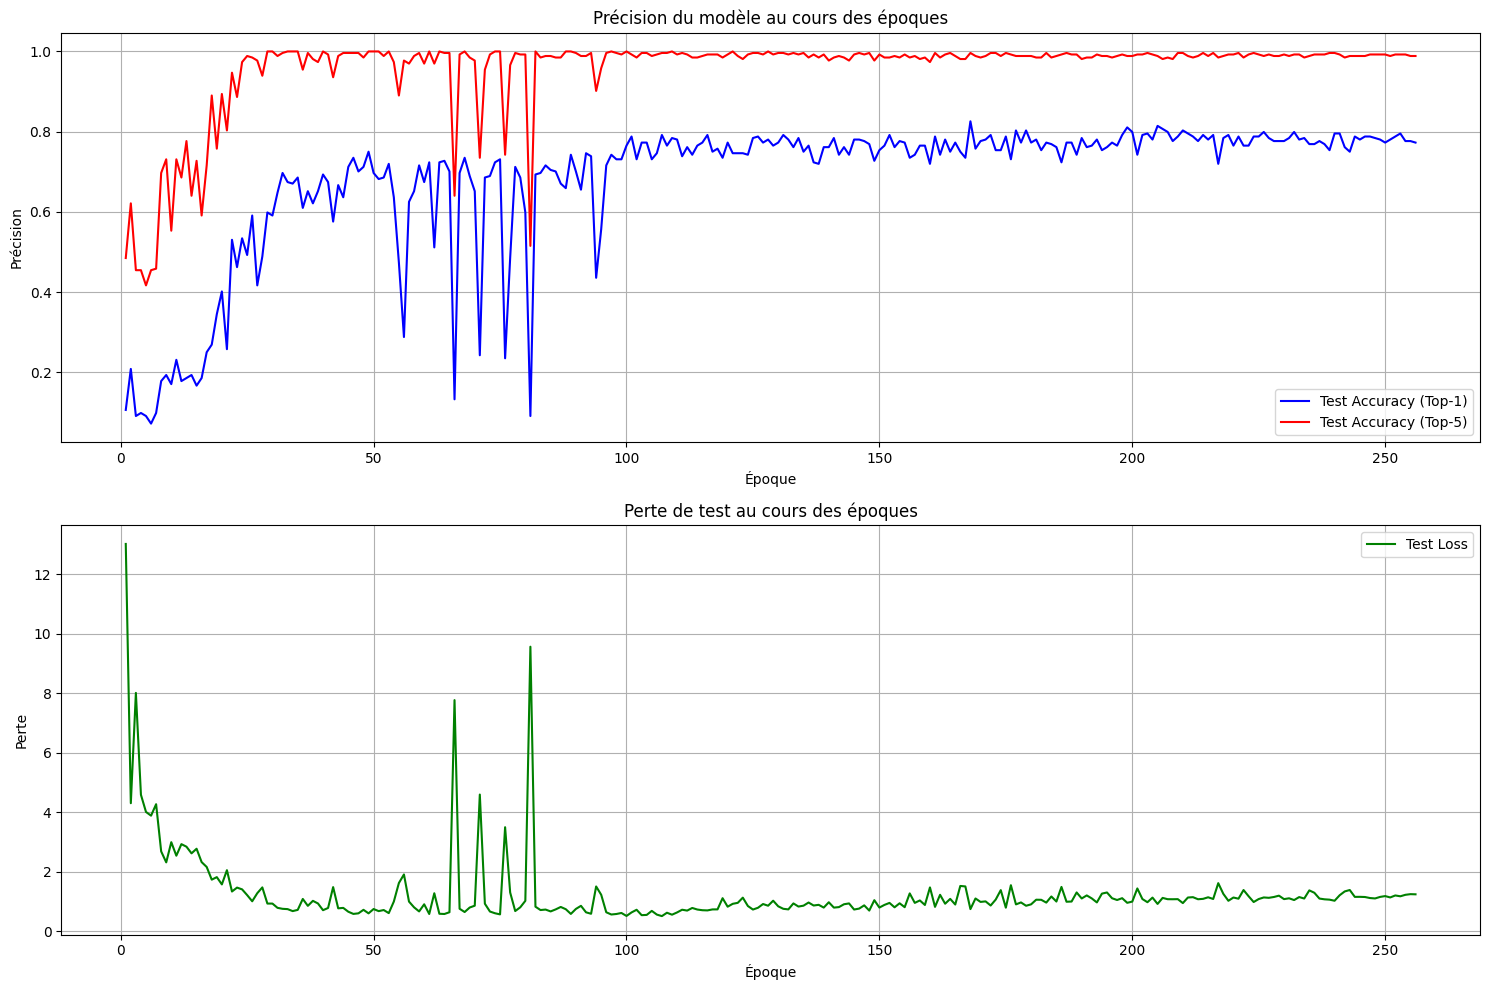

Meilleure précision: 0.8258 à l'époque 168.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix, top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

BEGIN_EPOCH = 0
MAX_EPOCH = 50
TOP_K = 5
max_acc, best_epoch = plot_learning_curves(Record_path, Name_suffix, TOP_K)
print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")